In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 8.4 MB/s eta 0:00:00


[I 2025-06-20 13:44:02,726] A new study created in memory with name: no-name-96481a3b-ad59-40bc-9253-7e8525939026
/tmp/ipython-input-8-3452409014.py:170: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ridge_alpha=trial.suggest_loguniform('ridge_alpha', 1e-8, 1e-2),
[I 2025-06-20 13:44:06,989] Trial 0 finished with value: 0.27825323445210576 and parameters: {'res_size': 270, 'spectral_radius': 1.494266501743001, 'leak_rate': 0.28132493917202706, 'ridge_alpha': 0.0002909629562519868}. Best is trial 0 with value: 0.27825323445210576.
/tmp/ipython-input-8-3452409014.py:170: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ridge_alpha=trial.suggest_loguniform('ridge_alpha', 1e-8

Best Parameters: {'res_size': 481, 'spectral_radius': 1.3615485626010286, 'leak_rate': 0.43528577667431406, 'ridge_alpha': 1.6939379415690365e-05}
📊 AAPL: Accuracy=0.2682, F1=0.2438


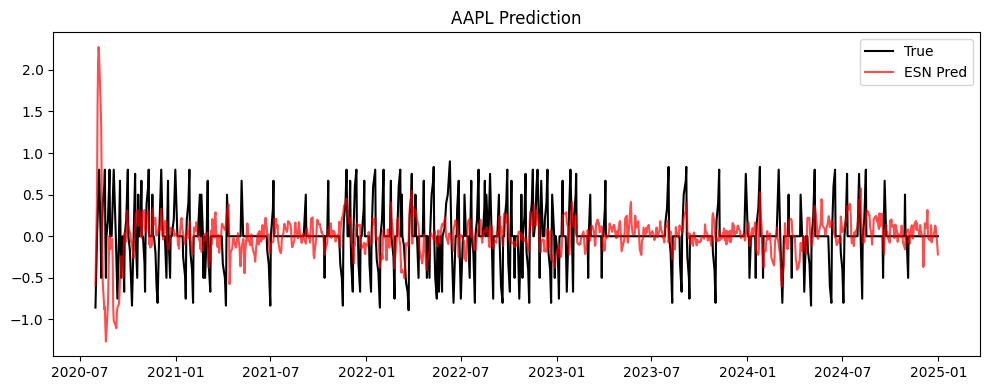

📊 MSFT: Accuracy=0.2215, F1=0.2106


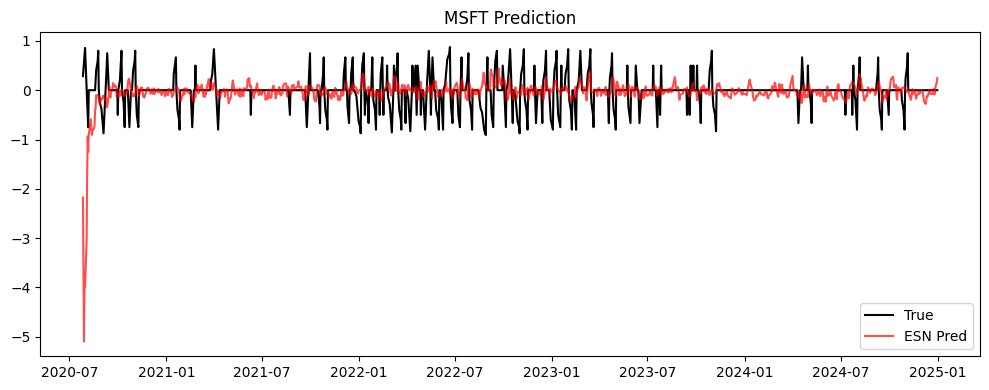

📊 NVDA: Accuracy=0.4051, F1=0.2938


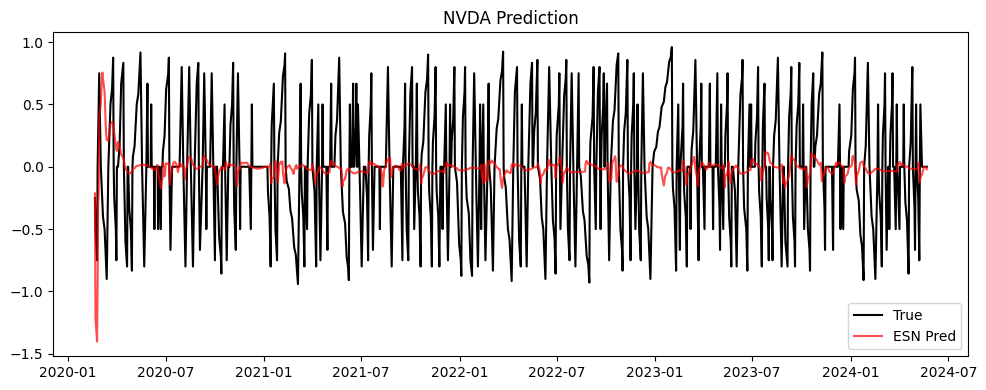

📊 AMZN: Accuracy=0.2992, F1=0.2557


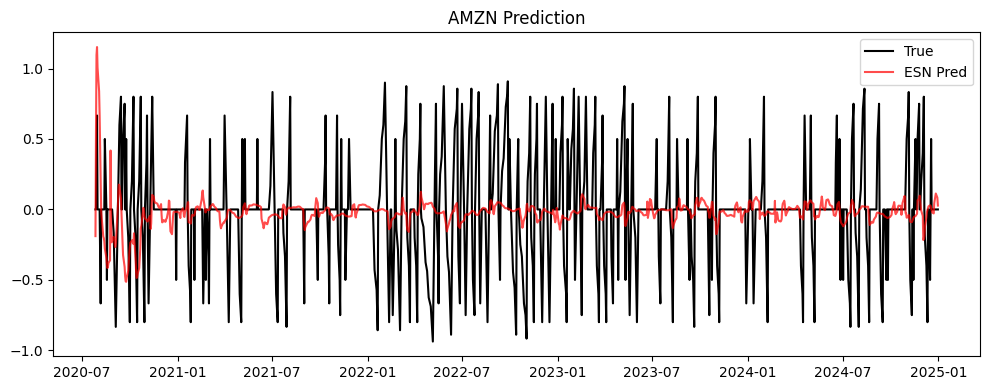

📊 META: Accuracy=0.3459, F1=0.2748


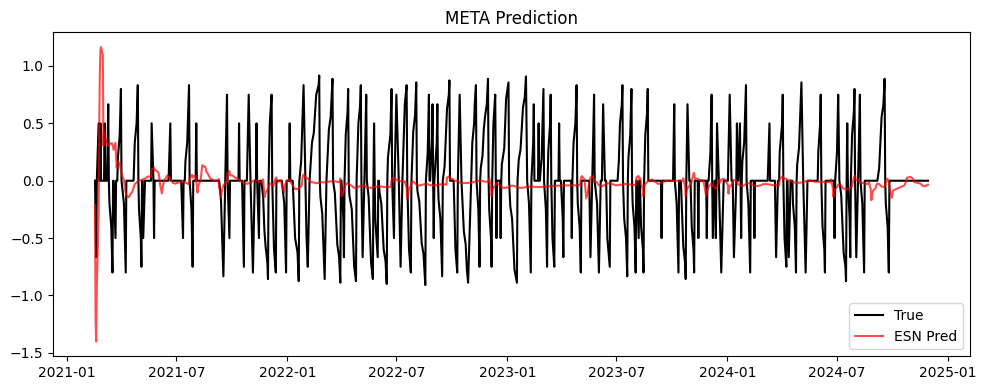

📊 BRK-B: Accuracy=0.1319, F1=0.1406


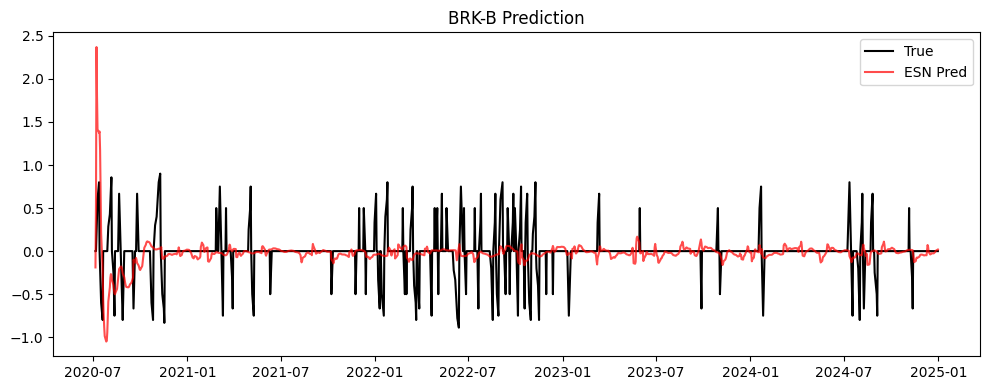

📊 GOOGL: Accuracy=0.2947, F1=0.2546


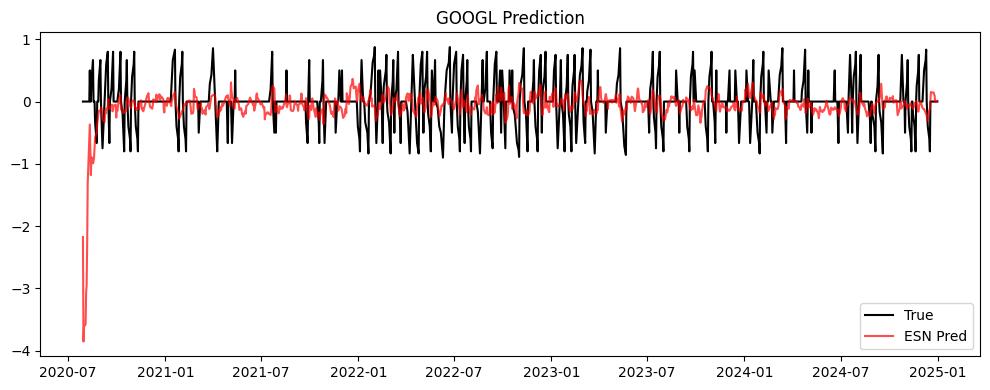

📊 JNJ: Accuracy=0.1178, F1=0.1296


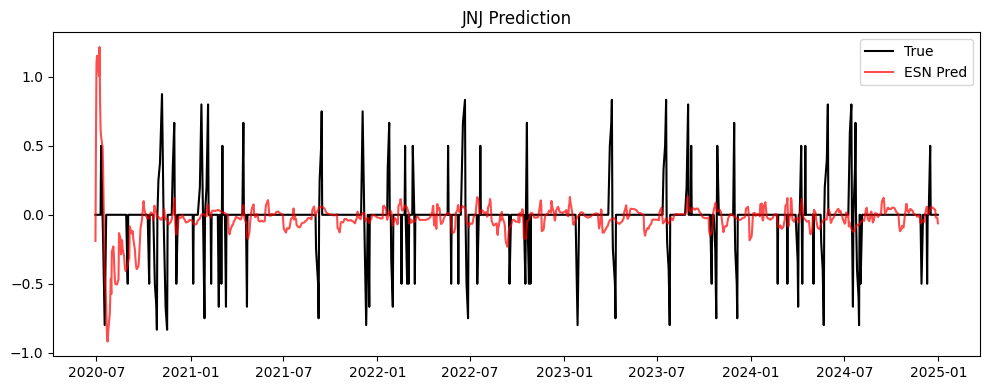

📊 UNH: Accuracy=0.1625, F1=0.1667


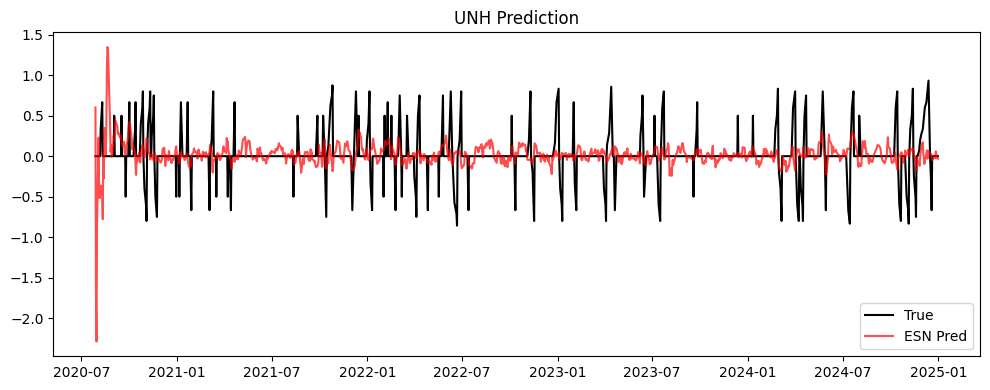

📊 TSLA: Accuracy=0.4270, F1=0.3010


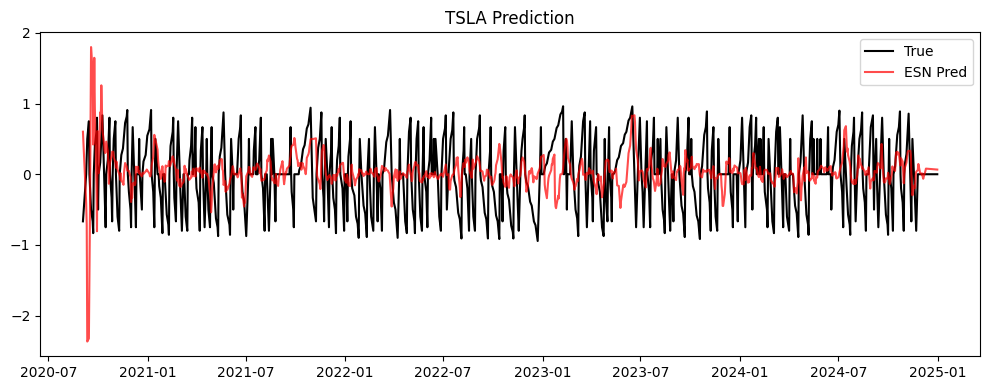

In [8]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score, accuracy_score
import optuna

# ───────────────────────────────────────────────
# 1. 공통 지표 목록
INDICATOR_LIST = ['sma', 'ema', 'rsi', 'macd', 'bb']

# ───────────────────────────────────────────────
# 2. 지표 파라미터 로드
def load_selected_indicators(path, ticker):
    df = pd.read_csv(path)
    df = df[df['Ticker'] == ticker]

    selected = {}
    for _, row in df.iterrows():
        if row['Use'] == 1:
            param_str = row['Params_Opt'] if pd.notnull(row['Params_Opt']) else row['Params_Emp']
            try:
                selected[row['Indicator'].lower()] = ast.literal_eval(param_str)
            except:
                continue
    return selected

# ───────────────────────────────────────────────
# 3. 기술적 지표 계산 함수
def calc_signals(df, params):
    close = df['Close']
    signals = pd.DataFrame(index=df.index)

    # 각 지표별 계산
    if 'sma' in params:
        window = params['sma'][0]
        sma = close.rolling(window).mean()
        signals['sma'] = np.where(close > sma, -1, 1)

    if 'ema' in params:
        span = params['ema'][0]
        ema = close.ewm(span=span, adjust=False).mean()
        signals['ema'] = np.where(close > ema, -1, 1)

    if 'rsi' in params:
        w, lo = params['rsi']
        delta = close.diff()
        up = delta.clip(lower=0).rolling(w).mean()
        down = -delta.clip(upper=0).rolling(w).mean()
        rsi = 100 - 100 / (1 + up / down)
        sig = pd.Series(0, index=df.index)
        sig[rsi < lo] = -1
        sig[rsi > 100 - lo] = 1
        signals['rsi'] = sig

    if 'macd' in params:
        f, s, sl = params['macd']
        ema_f = close.ewm(span=f, adjust=False).mean()
        ema_s = close.ewm(span=s, adjust=False).mean()
        macd_line = ema_f - ema_s
        macd_sig = macd_line.ewm(span=sl, adjust=False).mean()
        cross = macd_line - macd_sig
        sig = pd.Series(0, index=df.index)
        sig[(cross.shift(1) < 0) & (cross > 0)] = -1
        sig[(cross.shift(1) > 0) & (cross < 0)] = 1
        signals['macd'] = sig

    if 'bb' in params:
        w, ns = params['bb']
        ma = close.rolling(w).mean()
        std = close.rolling(w).std()
        upper = ma + ns * std
        lower = ma - ns * std
        sig = pd.Series(0, index=df.index)
        sig[close < lower] = -1
        sig[close > upper] = 1
        signals['bb'] = sig

    # 누락된 지표는 0으로 채움
    for ind in INDICATOR_LIST:
        if ind not in signals.columns:
            signals[ind] = 0

    return signals[INDICATOR_LIST].fillna(0)

# ───────────────────────────────────────────────
# 4. ESN 클래스
class ESN:
    def __init__(self, in_dim, res_size=200, spectral_radius=0.9,
                 sparsity=0.1, leak_rate=0.3, ridge_alpha=1e-6, random_state=42):
        self.in_dim = in_dim
        self.res_size = res_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.leak_rate = leak_rate
        self.ridge_alpha = ridge_alpha
        rng = np.random.RandomState(random_state)
        self.Win = (rng.rand(res_size, in_dim + 1) - 0.5)
        W = rng.rand(res_size, res_size) - 0.5
        W[rng.rand(*W.shape) > sparsity] = 0
        W *= spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, inp):
        pre = np.dot(self.Win, np.hstack([1, inp])) + np.dot(self.W, state)
        return (1 - self.leak_rate) * state + self.leak_rate * np.tanh(pre)

    def fit(self, X, y):
        T = X.shape[0]
        states = np.zeros((T, self.res_size))
        s = np.zeros(self.res_size)
        for t in range(T):
            s = self._update(s, X[t])
            states[t] = s
        M = np.hstack([np.ones((T, 1)), X, states])
        self.model = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        self.model.fit(M, y)

    def predict(self, X):
        T = X.shape[0]
        states = np.zeros((T, self.res_size))
        s = np.zeros(self.res_size)
        for t in range(T):
            s = self._update(s, X[t])
            states[t] = s
        M = np.hstack([np.ones((T, 1)), X, states])
        return self.model.predict(M)

# ───────────────────────────────────────────────
# 5. 메인 실행
if __name__ == "__main__":
    tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'BRK-B', 'GOOGL', 'JNJ', 'UNH', 'TSLA']
    proc_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    targ_dir = '/content/drive/MyDrive/시계열/data/target'
    opt_path = '/content/drive/MyDrive/시계열/reports/optimization_results.csv'

    all_X_train, all_y_train = [], []
    per_stock_data = {}

    for ticker in tickers:
        df_price = pd.read_csv(f"{proc_dir}/{ticker}_processed.csv", parse_dates=['Date'], index_col='Date')
        df_targ = pd.read_csv(f"{targ_dir}/{ticker}_target.csv", parse_dates=['Date'], index_col='Date')
        df_targ['Target'] = df_targ['triangular_target']

        params = load_selected_indicators(opt_path, ticker)
        signals = calc_signals(df_price, params).values
        y = df_targ['Target'].values

        split = int(0.7 * len(y))
        X_train, X_test = signals[:split], signals[split:]
        y_train, y_test = y[:split], y[split:]

        all_X_train.append(X_train)
        all_y_train.append(y_train)
        per_stock_data[ticker] = {'X_test': X_test, 'y_test': y_test, 'index': df_targ.index[split:]}

    # 전체 학습 데이터 결합
    X_train_all = np.vstack(all_X_train)
    y_train_all = np.hstack(all_y_train)

    # Optuna 최적화
    def objective(trial):
        esn = ESN(
            in_dim=X_train_all.shape[1],
            res_size=trial.suggest_int('res_size', 50, 500),
            spectral_radius=trial.suggest_float('spectral_radius', 0.5, 1.5),
            leak_rate=trial.suggest_float('leak_rate', 0.1, 0.9),
            ridge_alpha=trial.suggest_loguniform('ridge_alpha', 1e-8, 1e-2),
            random_state=42
        )
        esn.fit(X_train_all, y_train_all)
        y_pred = esn.predict(X_train_all)
        true_dir = np.sign(y_train_all[1:] - y_train_all[:-1])
        pred_dir = np.sign(y_pred[1:] - y_pred[:-1])
        return f1_score(true_dir, pred_dir, average='macro')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    print("Best Parameters:", study.best_trial.params)

    # 최적 모델로 학습
    best = study.best_trial.params
    esn = ESN(
        in_dim=X_train_all.shape[1],
        res_size=best['res_size'],
        spectral_radius=best['spectral_radius'],
        leak_rate=best['leak_rate'],
        ridge_alpha=best['ridge_alpha'],
        random_state=42
    )
    esn.fit(X_train_all, y_train_all)

    # 종목별 평가 및 시각화
    for ticker in tickers:
        X_test = per_stock_data[ticker]['X_test']
        y_test = per_stock_data[ticker]['y_test']
        index = per_stock_data[ticker]['index']

        y_pred = esn.predict(X_test)
        y_test, y_pred = y_test[:len(y_pred)], y_pred[:len(y_test)]
        true_dir = np.sign(y_test[1:] - y_test[:-1])
        pred_dir = np.sign(y_pred[1:] - y_pred[:-1])
        acc = accuracy_score(true_dir, pred_dir)
        f1 = f1_score(true_dir, pred_dir, average='macro')

        print(f"📊 {ticker}: Accuracy={acc:.4f}, F1={f1:.4f}")

        # 시각화
        plt.figure(figsize=(10, 4))
        plt.plot(index[:len(y_test)], y_test, label='True', color='black')
        plt.plot(index[:len(y_pred)], y_pred, label='ESN Pred', color='red', alpha=0.7)
        plt.title(f"{ticker} Prediction")
        plt.legend()
        plt.tight_layout()
        plt.show()


[I 2025-06-20 13:20:26,809] A new study created in memory with name: no-name-201322c5-262e-414d-b099-604a6191bb9c
[I 2025-06-20 13:20:27,028] Trial 0 finished with value: 0.3528671923338353 and parameters: {'max_depth': 8, 'eta': 0.04695879487154348, 'subsample': 0.5581289530787228, 'colsample_bytree': 0.9094763235567245, 'lambda': 1.2353640029350772e-08, 'alpha': 2.643934480027735e-06}. Best is trial 0 with value: 0.3528671923338353.
[I 2025-06-20 13:20:27,181] Trial 1 finished with value: 0.3528671923338353 and parameters: {'max_depth': 10, 'eta': 0.01821912819296559, 'subsample': 0.7502819752035856, 'colsample_bytree': 0.5778160429781412, 'lambda': 0.028155712408086266, 'alpha': 0.0020559936728642867}. Best is trial 0 with value: 0.3528671923338353.
[I 2025-06-20 13:20:27,265] Trial 2 finished with value: 0.35077731244787697 and parameters: {'max_depth': 10, 'eta': 0.2353382475301829, 'subsample': 0.8581411979018819, 'colsample_bytree': 0.7776644529558174, 'lambda': 2.26401408567983

🎯 Best Trial Parameters:
max_depth: 8
eta: 0.04695879487154348
subsample: 0.5581289530787228
colsample_bytree: 0.9094763235567245
lambda: 1.2353640029350772e-08
alpha: 2.643934480027735e-06

📊 최종 XGBoost 성능
Accuracy: 0.5338
F1 Score: 0.2320


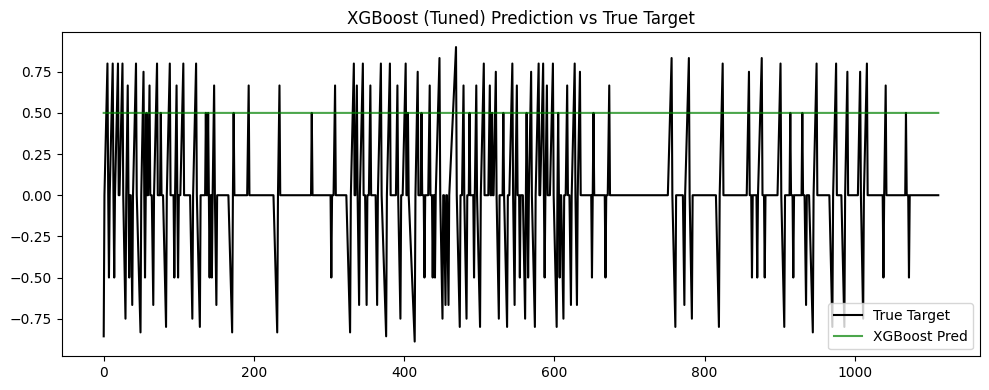

In [3]:
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

def objective(trial):
    # 하이퍼파라미터 샘플링
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'seed': 42
    }

    # DMatrix 생성
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 학습
    bst = xgb.train(param, dtrain, num_boost_round=200, evals=[(dval, "val")],
                    early_stopping_rounds=20, verbose_eval=False)

    # 예측
    y_pred = bst.predict(dval)
    y_pred = y_pred[:len(y_val)]

    # 방향성 기반 평가
    true_dir = np.sign(y_val[1:] - y_val[:-1])
    pred_dir = np.sign(y_pred[1:] - y_pred[:-1])

    return f1_score(true_dir, pred_dir, average='macro')

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 파라미터 출력
print("🎯 Best Trial Parameters:")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")

# ✅ 최적 파라미터로 재학습
best_params = study.best_trial.params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['seed'] = 42

# 재분할 (전체 데이터 기준)
split = int(0.7 * len(X))
X_train_final, X_test = X[:split], X[split:]
y_train_final, y_test = y[:split], y[split:]

dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final)
dtest = xgb.DMatrix(X_test, label=y_test)

# 모델 학습
final_model = xgb.train(best_params, dtrain_final, num_boost_round=study.best_trial.number)

# 예측
y_pred = final_model.predict(dtest)
min_len = min(len(y_pred), len(y_test))
y_test_cut = y_test[:min_len]
y_pred_cut = y_pred[:min_len]

# 방향성 평가
true_dir = np.sign(y_test_cut[1:] - y_test_cut[:-1])
pred_dir = np.sign(y_pred_cut[1:] - y_pred_cut[:-1])
acc = accuracy_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir, average='macro')

print("\n📊 최종 XGBoost 성능")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(y_test_cut, label='True Target', color='black')
plt.plot(y_pred_cut, label='XGBoost Pred', color='green', alpha=0.7)
plt.title("XGBoost (Tuned) Prediction vs True Target")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd

def backtest_performance(pred_signal, close_prices, transaction_cost=0.001):
    """
    pred_signal: np.array of {-1, 0, 1}
    close_prices: np.array of close prices (same length)
    """
    pred_signal = np.array(pred_signal)
    close_prices = np.array(close_prices)

    # 수익률 계산
    returns = np.diff(close_prices) / close_prices[:-1]
    signal = pred_signal[:-1]  # 다음 날 수익률에 오늘 시그널 적용
    strat_ret = signal * returns - transaction_cost * np.abs(np.diff(signal, prepend=0))

    # 누적 수익률
    cum_ret = np.cumprod(1 + strat_ret) - 1

    # 샤프지수 (연율화 기준 가정: 252 거래일)
    excess_ret = strat_ret - 0.0001  # 무위험 수익률 대체값
    sharpe = np.mean(excess_ret) / (np.std(excess_ret) + 1e-8) * np.sqrt(252)

    # MDD
    cum_val = np.cumprod(1 + strat_ret)
    peak = np.maximum.accumulate(cum_val)
    drawdown = (cum_val - peak) / peak
    mdd = np.min(drawdown)

    return {
        "Cumulative Return": cum_ret[-1],
        "Sharpe Ratio": sharpe,
        "MDD": mdd
    }

def buy_hold_performance(close_prices):
    returns = np.diff(close_prices) / close_prices[:-1]
    strat_ret = returns  # 항상 보유
    cum_ret = np.cumprod(1 + strat_ret) - 1
    sharpe = np.mean(strat_ret) / (np.std(strat_ret) + 1e-8) * np.sqrt(252)

    cum_val = np.cumprod(1 + strat_ret)
    peak = np.maximum.accumulate(cum_val)
    drawdown = (cum_val - peak) / peak
    mdd = np.min(drawdown)

    return {
        "Cumulative Return": cum_ret[-1],
        "Sharpe Ratio": sharpe,
        "MDD": mdd
    }

# 신호 생성: 예측 수익률 > 0 → 매수, < 0 → 매도
pred_signal = np.sign(y_pred[:min_len])  # 예측 기반 신호
close = df_price['Close'].values[-len(y_test):]  # 예측 구간의 종가

bt_lstm = backtest_performance(pred_signal, close[:min_len])
bt_bnh  = buy_hold_performance(close[:min_len])

print("\n📈 [ESN 전략]")
for k, v in bt_lstm.items():
    print(f"{k}: {v:.4f}")

print("\n📊 [Buy & Hold 전략]")
for k, v in bt_bnh.items():
    print(f"{k}: {v:.4f}")



📈 [ESN 전략]
Cumulative Return: -0.2450
Sharpe Ratio: -0.1572
MDD: -0.5296

📊 [Buy & Hold 전략]
Cumulative Return: 1.5025
Sharpe Ratio: 0.8593
MDD: -0.3194


/tmp/ipython-input-12-3037434686.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-12-3037434686.py:34: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


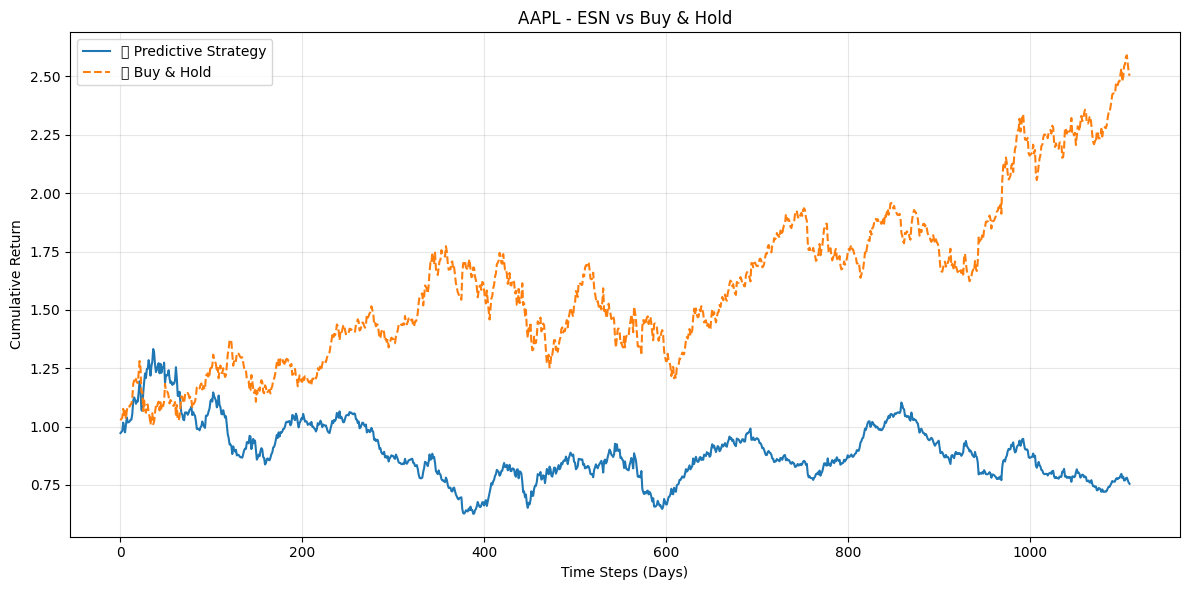

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_returns(pred_signal, close_prices, title="Cumulative Return Comparison", transaction_cost=0.001):
    """
    pred_signal: 예측 시그널 (np.array), {-1, 0, 1}
    close_prices: 종가 시계열 (np.array)
    """

    pred_signal = np.array(pred_signal)
    close_prices = np.array(close_prices)

    # 수익률 계산
    returns = np.diff(close_prices) / close_prices[:-1]

    # 예측 전략 수익률
    signal = pred_signal[:-1]
    strategy_returns = signal * returns - transaction_cost * np.abs(np.diff(signal, prepend=0))
    cumulative_strategy = np.cumprod(1 + strategy_returns)

    # Buy & Hold 수익률
    buy_hold_returns = returns
    cumulative_bnh = np.cumprod(1 + buy_hold_returns)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_strategy, label='📈 Predictive Strategy')
    plt.plot(cumulative_bnh, label='💼 Buy & Hold', linestyle='--')
    plt.title(title)
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예측 결과로 시그널 생성
pred_signal = np.sign(y_pred[:min_len])
close = df_price['Close'].values[-len(y_test):]  # test 시점 종가
close_cut = close[:min_len]

# 시각화 호출
plot_cumulative_returns(pred_signal, close_cut, title=f"{ticker} - ESN vs Buy & Hold")
